# core

> Fill in a module description here

In [ ]:
#| default_exp core

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
def foo(): pass

In [ ]:
from backtest_sample.data_interface import *

In [ ]:
import_module = get_data()
df = import_module('BTC-USD').sim_data()
print(df)

[*********************100%***********************]  1 of 1 completed

                    Open          High  ...     Adj Close       Volume
Date                                    ...                           
2014-09-17    465.864014    468.174011  ...    457.334015     21056800
2014-09-18    456.859985    456.859985  ...    424.440002     34483200
2014-09-19    424.102997    427.834991  ...    394.795990     37919700
2014-09-20    394.673004    423.295990  ...    408.903992     36863600
2014-09-21    408.084991    412.425995  ...    398.821014     26580100
...                  ...           ...  ...           ...          ...
2024-09-12  57343.171875  58534.359375  ...  58127.011719  33835707949
2024-09-13  58130.324219  60648.023438  ...  60571.300781  32490528356
2024-09-14  60569.117188  60656.722656  ...  60005.121094  16428405496
2024-09-15  60000.726562  60381.917969  ...  59182.835938  18120960867
2024-09-16  59141.949219  59195.609375  ...  57951.300781  33599461376

[3653 rows x 6 columns]
                    Open          High  ...     Adj 

In [ ]:
er = get_er()
prm = {}
prm['mawin'] = 10
prm['sdwin'] = 30
yHat = er(df.values,prm).y_hat()
risk = get_risk()
prm = {}
prm['wvol'] = 60
riskHat = risk(df.values,prm).risk_hat()

In [ ]:
tc_func = get_tc()
prm['tc_slope'] = 1e3
prm['tc_bias'] = 100
tcc = tc_func(df.values,prm)
print(tcc.TC(100))

{'TC': 108.49373707874257}
{'TC': 108.49373707874257}


In [ ]:
prm = {}
prm['target_vol'] = 0.005
prm['AUM'] = 10e6
alloc = get_pm()
pm = alloc(df.values,prm)
print(pm.allocation(1,0.04))

{'N': 22}
{'N': 22}


In [ ]:
when_trade = 'open'
start_date = 100
prm['mawin'] = 10
prm['sdwin'] = 30
prm['wvol']  = 60
prm['target_vol'] = 0.005
prm['AUM'] = 10e6
prm['tc_slope'] = 1e3
prm['tc_bias'] = 100
time_line = df.index.values
model_prices = df.values # ohlcav
if when_trade == 'open':
    trade_price = 0 
else:
    trade_price = 4
position = []
target_er   = []
target_risk = []
# Create a 2D array with 3 rows and 4 columns, initialized to None
position = []
#[t_trade,t_n_new,t_yHat['y_hat'],t_rHat['vol_hat'],float(t_scale),pnl0,pnl]
colnames = ['trade','position','ER','Risk','scale','pnl0','pnl']
items = [0 for _ in range(len(colnames))]
t_loop = time_line#[:(start_date+100)]
for tt in t_loop:
    if tt<time_line[start_date]:
       position.append(items)
       continue
    # PM
    t_data = model_prices[time_line<tt,:]
    t_yHat = er(t_data,prm).y_hat()
    t_rHat = risk(t_data,prm).risk_hat()
    t_p   = t_data[-1,4]
    t_pp  = t_data[-2,4]
    t_tp  = t_data[-1,trade_price]
    t_tpp = t_data[-2,trade_price]
    t_n_new = pm.allocation(t_yHat['y_hat'],t_rHat['vol_hat'],t_p)
    #t_scale = round(prm['AUM']*prm['target_vol']/t_p,4)
    #t_n_new = round(t_scale*t_yHat['y_hat']/t_rHat['vol_hat'])

    #print(t_n)
    # Accountant
    n_t_minus1 = position[-2][1]
    n_t = position[-1][1]
    trade_t = n_t*t_tp # N(t)*trade_price(t)
    model_t = n_t*t_p # N(t)*model_price(t)
    trade_t_minus1 = n_t_minus1*t_tp
    model_t_minus1 = n_t_minus1*t_pp
    pnl0 = (model_t-trade_t)+(trade_t_minus1-model_t_minus1)
    tc0  = (n_t-n_t_minus1)
    tcc    = tc_func(t_data,prm).TC(tc0)
    pnl = pnl0-tcc['TC']
    #target position  
    t_trade = t_n_new['N'] - n_t

    position.append([t_trade,t_n_new['N'],t_yHat['y_hat'],t_rHat['vol_hat'],float(t_scale),float(pnl0),float(pnl)])

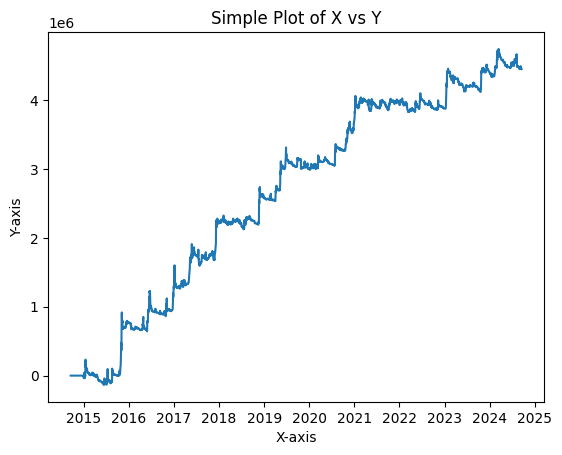

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the data
plt.plot(t_loop,np.cumsum(np.array(position)[:,-1]))

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Simple Plot of X vs Y')

# Show the plot
plt.show()


In [ ]:
import pandas as pd
pd.DataFrame(position,index=time_line,columns=colnames)

,trade,position,ER,Risk,scale,pnl0,pnl
2014-09-17,0,0,0.0000,0.0000,0.0000,0.000000,0.000000
2014-09-18,0,0,0.0000,0.0000,0.0000,0.000000,0.000000
2014-09-19,0,0,0.0000,0.0000,0.0000,0.000000,0.000000
2014-09-20,0,0,0.0000,0.0000,0.0000,0.000000,0.000000
2014-09-21,0,0,0.0000,0.0000,0.0000,0.000000,0.000000
...,...,...,...,...,...,...,...
2024-09-12,3,0,0.0012,0.0308,0.8448,915.039062,814.951086
2024-09-13,-2,-2,-0.0673,0.0307,0.8448,0.000000,-100.264222
2024-09-14,8,6,0.2064,0.0300,0.8448,-4881.953125,-4982.128923
2024-09-15,-2,4,0.1360,0.0300,0.8448,-3379.609375,-3480.283094


In [ ]:
position[-1]

[2, 6, 0.2066, 0.03, 0.8448, -3297.9296875, -3398.099201161006]

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()